# <font color=darkgreen>Dutch Rental Prices</font>

## <font color=teal>Purpose</font>

*Predicting the rent prices from Funda in the Netherlands*

## <font color=teal>Imports</font>

> **<font color=brown>Libraries</font>**

In [364]:
# Data manipulation
import pandas as pd
import numpy as np
import sidetable as stb

#ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Options for pandas
pd.options.display.max_columns
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input,Output

20

> **<font color=brown>Data</font>**

In [2]:
df = pd.read_json('/Users/michaelcondon/Desktop/Projects_files/Data_Science/properties.json', lines=True)

## <font color=teal>EDA</font>

> **<font color=brown>Overview</font>**
> 1. Dropping non-needed columns
> 2. Missing values
> 3. All continuous values
> 4. Distribution of continuous values
> 5. Categorical values
> 6. Cardinality of categorical values
> 7. Outliers
> 8. Relationship between indeendant and dependant variables

In [3]:
data = df

In [4]:
data.head(2)

,_id,externalId,areaRaw,areaSqm,city,coverImageUrl,crawlStatus,crawledAt,datesPublished,firstSeenAt,...,roommates,shower,smokingInside,toilet,userDisplayName,userId,userLastLoggedOn,userMemberSince,userPhotoUrl,additionalCostsDescription
0,{'$oid': '5d2b113a43cbfd7c77a998f4'},room-1686123,14 m2,14,Rotterdam,https://resources.kamernet.nl/image/913b4b03-5...,done,{'$date': '2019-07-26T22:18:23.018+0000'},"[{'$date': '2019-07-14T11:25:46.511+0000'}, {'...",{'$date': '2019-07-14T11:25:46.511+0000'},...,5,Shared,No,Shared,Huize west,4680711.0,21-07-2019,26-06-2019,https://resources.kamernet.nl/Content/images/s...,NaN
1,{'$oid': '5d2b113a43cbfd7c77a9991a'},studio-1691193,30 m2,30,Amsterdam,https://resources.kamernet.nl/image/5e11d6b5-8...,done,{'$date': '2019-08-10T22:28:46.099+0000'},"[{'$date': '2019-07-14T11:25:46.677+0000'}, {'...",{'$date': '2019-07-14T11:25:46.677+0000'},...,None,Own,No,Own,Cor,1865530.0,20-07-2019,05-01-2012,https://resources.kamernet.nl/Content/images/p...,NaN


In [5]:
data.shape

(46722, 62)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46722 entries, 0 to 46721
Data columns (total 62 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _id                          46722 non-null  object 
 1   externalId                   46722 non-null  object 
 2   areaRaw                      46722 non-null  object 
 3   areaSqm                      46722 non-null  int64  
 4   city                         46722 non-null  object 
 5   coverImageUrl                46722 non-null  object 
 6   crawlStatus                  46722 non-null  object 
 7   crawledAt                    46722 non-null  object 
 8   datesPublished               46722 non-null  object 
 9   firstSeenAt                  46722 non-null  object 
 10  furnish                      46722 non-null  object 
 11  lastSeenAt                   46722 non-null  object 
 12  latitude                     46722 non-null  float64
 13  longitude       

> **<font color=brown>Dropping columns with +50% nulls</font>**

In [7]:
data = data.drop(['deposit', 'additionalCostsDescription', 'additionalCosts', 'registrationCost'], axis=1)

> **<font color=brown>Dropping unneeded columns</font>**

In [8]:
data = data.drop(['_id','coverImageUrl','crawlStatus', 'crawledAt', 'datesPublished', 'url', 'source',
              'descriptionNonTranslated','descriptionNonTranslatedRaw','descriptionTranslated',
              'descriptionTranslatedRaw', 'detailsCrawledAt', 'pageDescription', 'pageTitle','userDisplayName',
              'userId','userLastLoggedOn','userMemberSince','userPhotoUrl', 'areaRaw', 'additionalCostsRaw','rentRaw','registrationCostRaw','depositRaw'], axis=1)

In [9]:
cols = list(data.columns)

> **<font color=brown>Continuous columns and fixing nulls<font>**

In [10]:
#creating a list of columns that have continuous values
continuous = []

for col in cols:
    if data[col].dtype != "O":
        continuous.append(col)


In [11]:
continuous

['areaSqm', 'latitude', 'longitude', 'rent']

In [12]:
#lat and long are location type and rent is our target, so these won't be used for our continuous list

del continuous[1:4]

In [13]:
for col in continuous:
    na = sum(data[col].isna())
    print ("The number of nulls in {} is {}".format(col,na))

The number of nulls in areaSqm is 0


In [14]:
data.areaSqm.describe()

count    46722.000000
mean        31.616626
std         29.863150
min          6.000000
25%         14.000000
50%         20.000000
75%         40.000000
max        675.000000
Name: areaSqm, dtype: float64

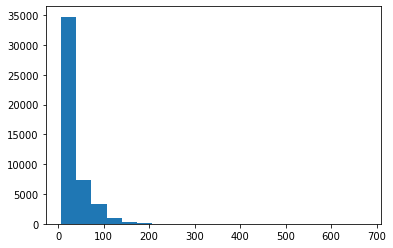

areaSqm is non-normally distributed


In [15]:
_=plt.hist(data.areaSqm, bins = 20)
plt.show()
print("areaSqm is non-normally distributed")

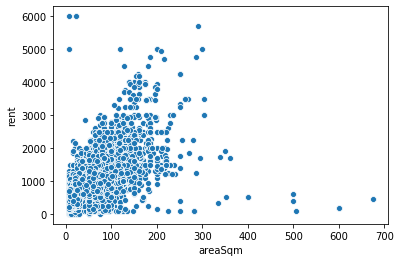

In [16]:
_ = sns.scatterplot(x=data.areaSqm,y=data.rent)

In [17]:
#use logarithmic trasnformation as data for areaSqm is not normally distributed

data['areaSqm_log'] = np.log(data.areaSqm)
data['rent_log'] = np.log(data.rent)

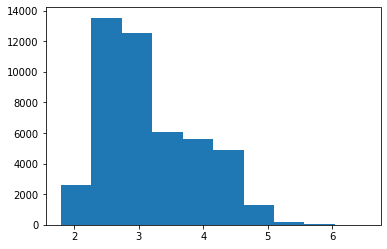

areaSqm is better distributed


In [18]:
_=plt.hist(data.areaSqm_log)
plt.show()
print("areaSqm is better distributed")

outliers exist in areaAqm


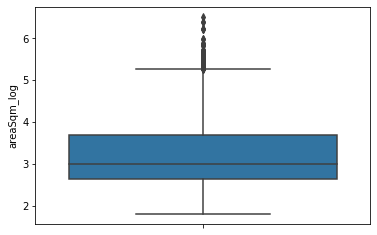

In [19]:
_=sns.boxplot(data.areaSqm_log, orient="vertical")
print("outliers exist in areaAqm")

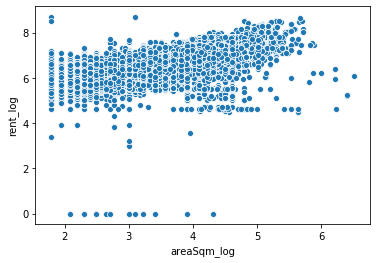

In [20]:
_ = sns.scatterplot(x=data.areaSqm_log,y=data.rent_log)

> <font color = brown>Categorical columns fixing nulls</font>

In [21]:
categorical = []

for col in cols:
    if data[col].dtype == "O":
        categorical.append(col)

In [22]:
data[categorical].head(1)

,externalId,city,firstSeenAt,furnish,lastSeenAt,postalCode,postedAgo,propertyType,rawAvailability,rentDetail,...,matchGender,matchGenderBackup,matchLanguages,matchStatus,matchStatusBackup,pets,roommates,shower,smokingInside,toilet
0,room-1686123,Rotterdam,{'$date': '2019-07-14T11:25:46.511+0000'},Unfurnished,{'$date': '2019-07-26T22:18:23.142+0000'},3074HN,4w,Room,26-06-'19 - Indefinite period,,...,Not important,Not important,Not important,Not important,Not important,No,5,Shared,No,Shared


In [23]:
#columns not needed for categorical list

categorical.remove("externalId")
categorical.remove("firstSeenAt")
categorical.remove("lastSeenAt")
categorical.remove("postedAgo")
categorical.remove("rawAvailability")
categorical.remove("matchStatus")
categorical.remove("matchStatusBackup")
categorical.remove("matchGenderBackup")


In [24]:
print("There are {} columns that are categorical".format(len(categorical)))

There are 22 columns that are categorical


In [25]:
#data[categorical] = data[categorical].astype('category')

In [26]:
cats_to_fix = []
for col in categorical:
    na = sum(data[col].isna())
    if na > 0:
        cats_to_fix.append(col)
    print ("The number of nulls in {} is {}".format(col,na))
print(cats_to_fix)
print("There are {} columns with null values that need to be addressed".format(len(cats_to_fix)))

The number of nulls in city is 0
The number of nulls in furnish is 0
The number of nulls in postalCode is 0
The number of nulls in propertyType is 0
The number of nulls in rentDetail is 0
The number of nulls in title is 0
The number of nulls in energyLabel is 100
The number of nulls in gender is 912
The number of nulls in internet is 100
The number of nulls in isRoomActive is 100
The number of nulls in kitchen is 100
The number of nulls in living is 100
The number of nulls in matchAge is 100
The number of nulls in matchAgeBackup is 100
The number of nulls in matchCapacity is 100
The number of nulls in matchGender is 100
The number of nulls in matchLanguages is 100
The number of nulls in pets is 100
The number of nulls in roommates is 912
The number of nulls in shower is 100
The number of nulls in smokingInside is 100
The number of nulls in toilet is 100
['energyLabel', 'gender', 'internet', 'isRoomActive', 'kitchen', 'living', 'matchAge', 'matchAgeBackup', 'matchCapacity', 'matchGender

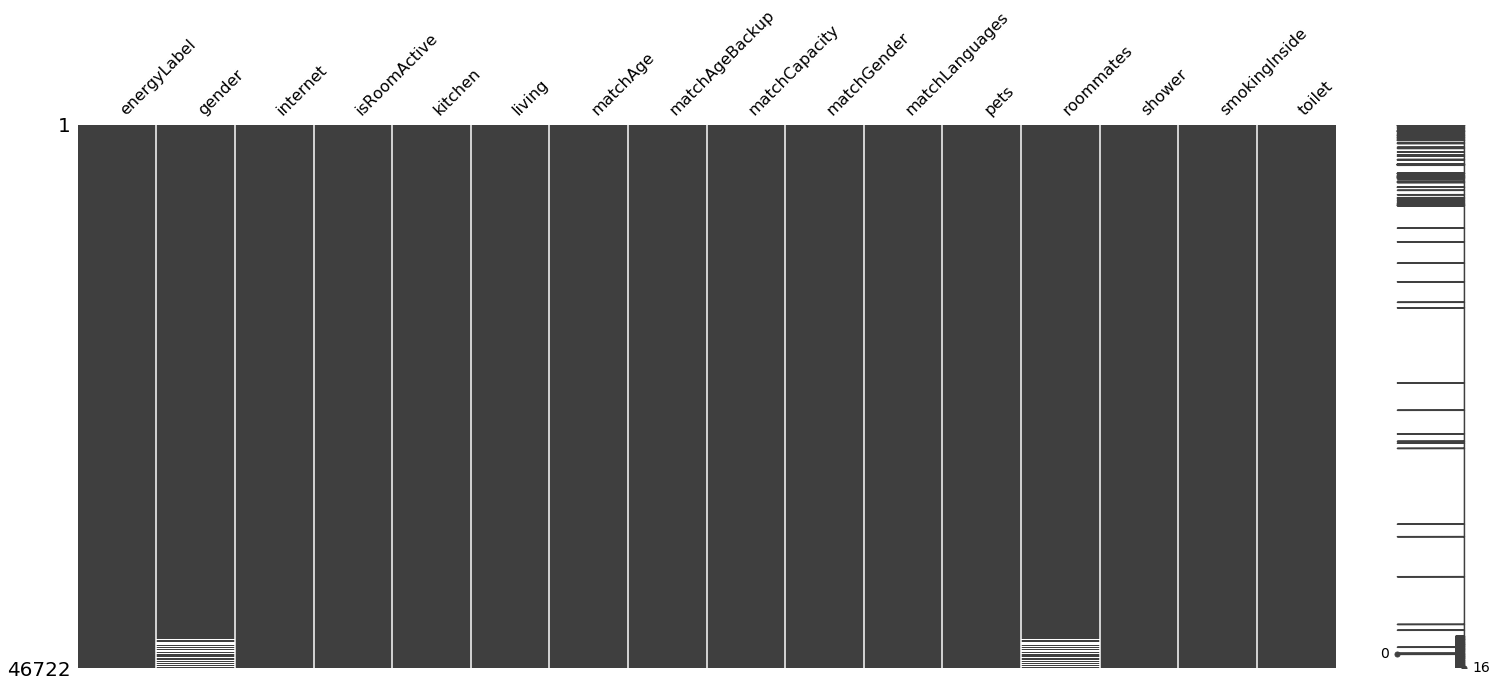

In [27]:
msno.matrix(data[cats_to_fix])

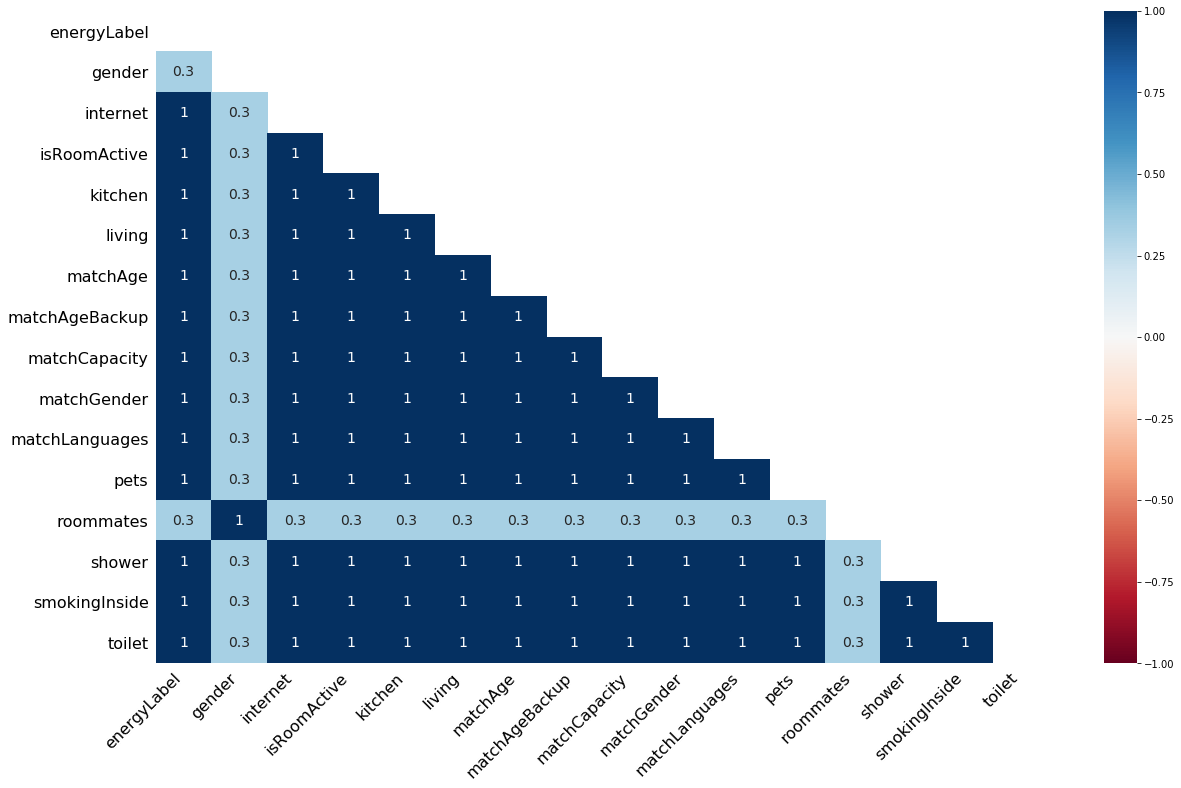

In [28]:
msno.heatmap(data[cats_to_fix])

In [29]:
#Heat map indicates there are rows with multiple missing values

data[cats_to_fix].isna().sum(axis=1).sort_values(ascending=False).value_counts()

0     45810
2       812
16      100
dtype: int64

In [30]:
#There are 100 rows with 17 missing values
#Dropping rows with more than 2 missing values

rows_to_drop = list(data.index[data[cats_to_fix].isna().sum(axis=1)>2])
data = data.drop(rows_to_drop, axis=0)
data.shape

(46622, 36)

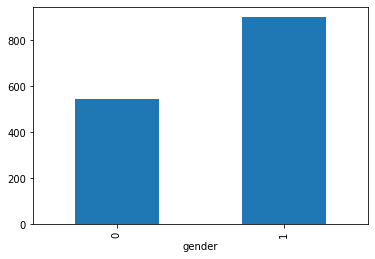

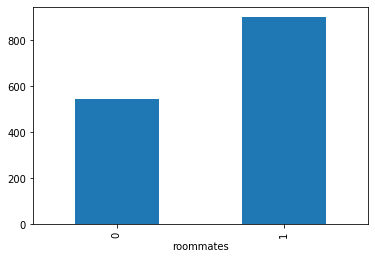

In [31]:
for col in data[['gender','roommates']]:
    temp_df = data
    
    #creating a variable that inidcates 1 if null or 0 if not
    temp_df[col] = np.where(temp_df[col].isna(),1,0)
    
    _ = temp_df.groupby(col)['rent'].median().plot.bar()
    plt.show()

The relation between the target (rent) and the missing values is higher than the present values, so we need to replace the nan's with something meaningful.

In [32]:
for col in categorical:
    print('There are {} missing values in {}'.format(sum(data[col] == ""),col))

There are 0 missing values in city
There are 362 missing values in furnish
There are 0 missing values in postalCode
There are 0 missing values in propertyType
There are 13208 missing values in rentDetail
There are 0 missing values in title
There are 0 missing values in energyLabel
There are 0 missing values in gender
There are 0 missing values in internet


/Users/michaelcondon/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



There are 0 missing values in isRoomActive
There are 0 missing values in kitchen
There are 0 missing values in living
There are 0 missing values in matchAge
There are 0 missing values in matchAgeBackup
There are 0 missing values in matchCapacity
There are 0 missing values in matchGender
There are 0 missing values in matchLanguages
There are 0 missing values in pets
There are 0 missing values in roommates
There are 0 missing values in shower
There are 0 missing values in smokingInside
There are 0 missing values in toilet


In [33]:
data[['furnish', 'rentDetail']] = data[['furnish', 'rentDetail']].replace(r'^\s*$', np.nan, regex=True)

In [34]:
data[categorical] = data[categorical].fillna('Missing')

In [35]:
for col in categorical:
    print('There are {} missing values in {}'.format(sum(data[col].isna()),col))
    

There are 0 missing values in city
There are 0 missing values in furnish
There are 0 missing values in postalCode
There are 0 missing values in propertyType
There are 0 missing values in rentDetail
There are 0 missing values in title
There are 0 missing values in energyLabel
There are 0 missing values in gender
There are 0 missing values in internet
There are 0 missing values in isRoomActive
There are 0 missing values in kitchen
There are 0 missing values in living
There are 0 missing values in matchAge
There are 0 missing values in matchAgeBackup
There are 0 missing values in matchCapacity
There are 0 missing values in matchGender
There are 0 missing values in matchLanguages
There are 0 missing values in pets
There are 0 missing values in roommates
There are 0 missing values in shower
There are 0 missing values in smokingInside
There are 0 missing values in toilet


Text(0.5, 0, 'furnish')

Text(0, 0.5, 'rent')

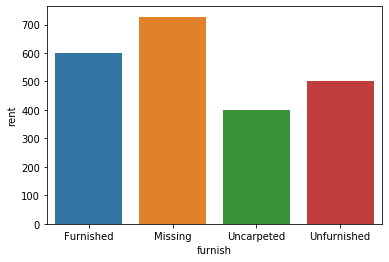

Text(0.5, 0, 'propertyType')

Text(0, 0.5, 'rent')

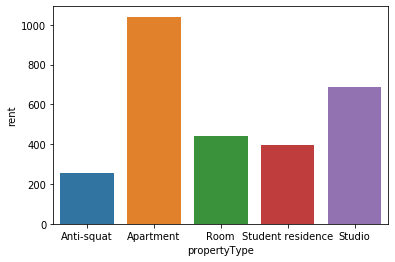

Text(0.5, 0, 'rentDetail')

Text(0, 0.5, 'rent')

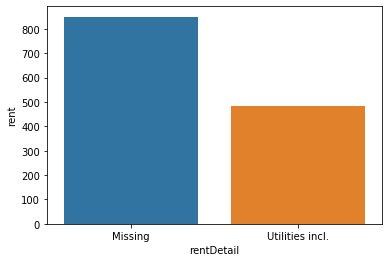

Text(0.5, 0, 'energyLabel')

Text(0, 0.5, 'rent')

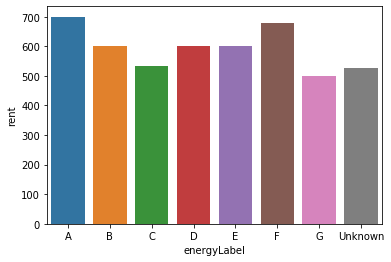

Text(0.5, 0, 'gender')

Text(0, 0.5, 'rent')

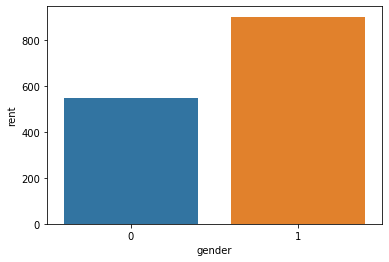

Text(0.5, 0, 'internet')

Text(0, 0.5, 'rent')

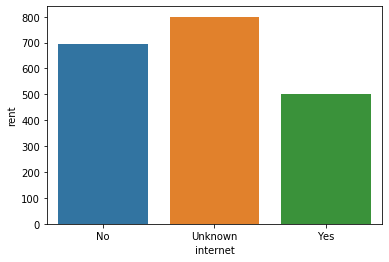

Text(0.5, 0, 'isRoomActive')

Text(0, 0.5, 'rent')

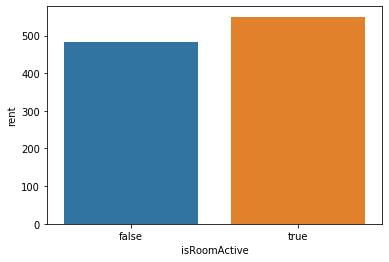

Text(0.5, 0, 'kitchen')

Text(0, 0.5, 'rent')

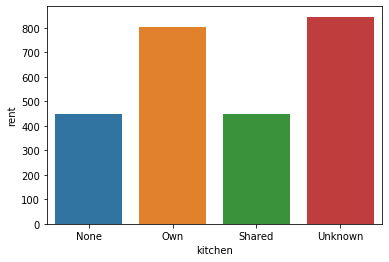

Text(0.5, 0, 'living')

Text(0, 0.5, 'rent')

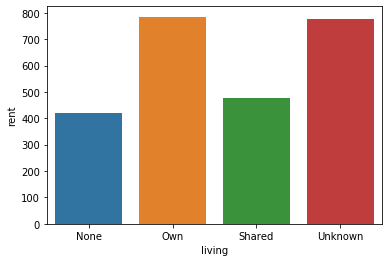

Text(0.5, 0, 'matchCapacity')

Text(0, 0.5, 'rent')

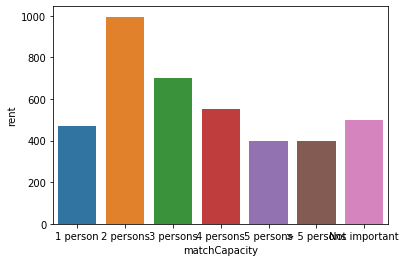

Text(0.5, 0, 'matchGender')

Text(0, 0.5, 'rent')

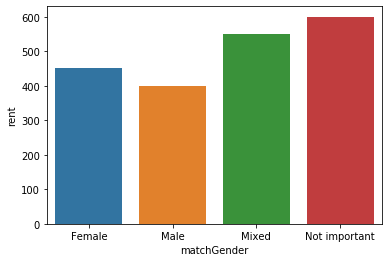

Text(0.5, 0, 'pets')

Text(0, 0.5, 'rent')

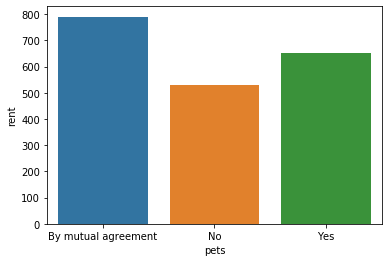

Text(0.5, 0, 'roommates')

Text(0, 0.5, 'rent')

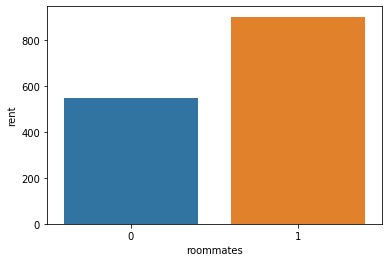

Text(0.5, 0, 'shower')

Text(0, 0.5, 'rent')

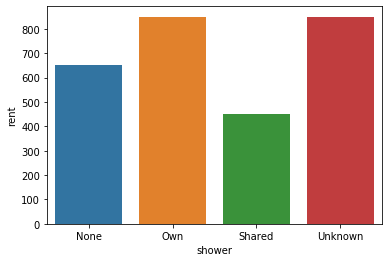

Text(0.5, 0, 'smokingInside')

Text(0, 0.5, 'rent')

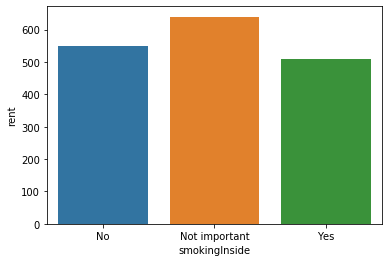

Text(0.5, 0, 'toilet')

Text(0, 0.5, 'rent')

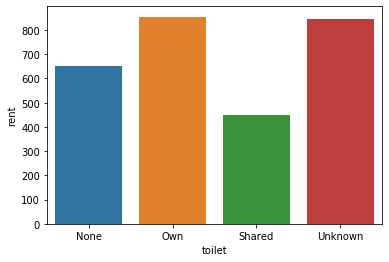

In [36]:
for col in categorical:
    if len(data.groupby(col)['rent'].median().reset_index()[col]) < 10:
        _=sns.barplot(x = data.groupby(col)['rent'].median().reset_index()[col],y = data.groupby(col)['rent'].median().reset_index()['rent'])
        plt.xlabel(col)
        plt.ylabel('rent')
        plt.show()

> **<font color=brown>Temporal</font>**

In [37]:
data['first_seen_date'] = data.firstSeenAt.apply(pd.Series)

In [38]:
data['last_seen_date'] = data.lastSeenAt.apply(pd.Series)

In [39]:
data = data.drop(['firstSeenAt','lastSeenAt'], axis=1)

In [40]:
temporal = ["first_seen_date","last_seen_date"]

In [41]:
for col in temporal:
    data[col] = data[col].astype(str).str[:10].astype(np.datetime64)

In [42]:
data[temporal].head(2)

,first_seen_date,last_seen_date
0,2019-07-14,2019-07-26
1,2019-07-14,2019-08-10


In [43]:
data['post_duration'] = (data.last_seen_date - data.first_seen_date).astype('str').str.split(" ", expand=True)[0].astype('int')

In [44]:
len(data[data.post_duration == 0])

2782

(array([3.3699e+04, 1.1581e+04, 6.2200e+02, 2.6400e+02, 1.9800e+02,
        8.6000e+01, 3.1000e+01, 4.4000e+01, 1.1000e+01, 8.6000e+01]),
 array([  0. ,  23.3,  46.6,  69.9,  93.2, 116.5, 139.8, 163.1, 186.4,
        209.7, 233. ]),
 <a list of 10 Patch objects>)

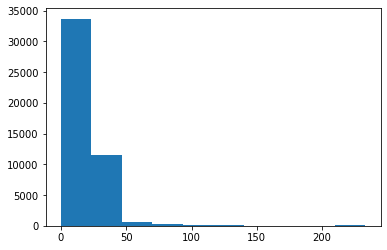

In [45]:
plt.hist(data.post_duration)

In [46]:
temporal = ["first_seen_date","last_seen_date", 'post_duration']

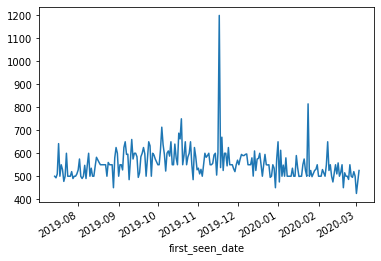

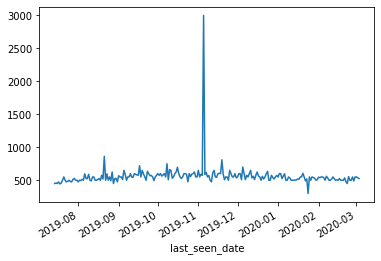

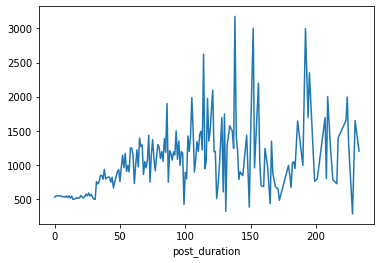

In [47]:
for col in temporal:
    _ = data.groupby(col)['rent'].median().plot()
    plt.show()

(737254.0, 737492.0)

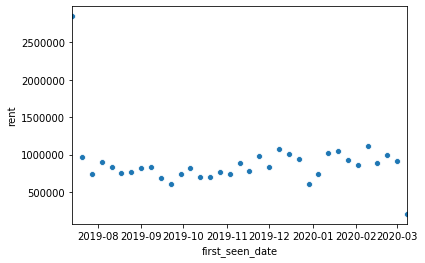

(737254.0, 737492.0)

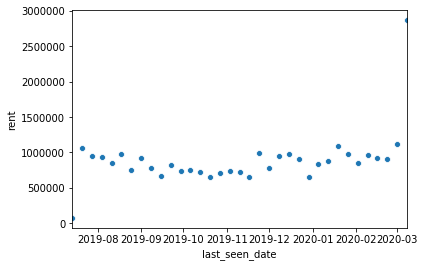

In [48]:
for col in temporal[0:2]:
    temp = data.set_index(col, drop=True)
    temp = temp.resample('W')['rent'].sum().reset_index()
    _ = sns.scatterplot(x = temp[col], y=temp.rent)
    plt.xlim(min(temp[col]), max(temp[col]))
    plt.show()

## <font color=teal>Feature Engineering</font>

In [346]:
#creating ML dataframe
data_ml = data.drop(['areaSqm','rent','latitude', 'longitude', 'postedAgo','matchGender', 'matchGenderBackup', 'matchCapacity', 'matchStatus', 'matchAgeBackup','matchAge', 'matchLanguages', 'matchStatusBackup', 'gender', 'rawAvailability', 'first_seen_date', 'last_seen_date', 'post_duration'], axis=1 )

In [347]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46622 entries, 0 to 46721
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   externalId     46622 non-null  object 
 1   city           46622 non-null  object 
 2   furnish        46622 non-null  object 
 3   postalCode     46622 non-null  object 
 4   propertyType   46622 non-null  object 
 5   rentDetail     46622 non-null  object 
 6   title          46622 non-null  object 
 7   energyLabel    46622 non-null  object 
 8   internet       46622 non-null  object 
 9   isRoomActive   46622 non-null  object 
 10  kitchen        46622 non-null  object 
 11  living         46622 non-null  object 
 12  pets           46622 non-null  object 
 13  roommates      46622 non-null  int64  
 14  shower         46622 non-null  object 
 15  smokingInside  46622 non-null  object 
 16  toilet         46622 non-null  object 
 17  areaSqm_log    46622 non-null  float64
 18  rent_l

In [348]:
ml_cat = []
ml_cont = []
ml_temp = []

for col in list(data_ml.columns):
    if data_ml[col].dtype == 'object':
        ml_cat.append(col)
    elif data_ml[col].dtype == 'datetime64[ns]':
        ml_temp.append(col)
    else:
        ml_cont.append(col)

ml_cat.append('roommates')
ml_cont.remove('roommates')
ml_cat.remove('externalId')

print('these are the ml_cat features {}'.format(ml_cat))
print('these are the ml_cont features {}'.format(ml_cont))
print('these are the ml_temp features {}'.format(ml_temp))



these are the ml_cat features ['city', 'furnish', 'postalCode', 'propertyType', 'rentDetail', 'title', 'energyLabel', 'internet', 'isRoomActive', 'kitchen', 'living', 'pets', 'shower', 'smokingInside', 'toilet', 'roommates']
these are the ml_cont features ['areaSqm_log', 'rent_log']
these are the ml_temp features []


> <font color=brown>Remove categorical values that represent less than 1% of observations</font>

for feature in ml_cat:
    temp = data_ml.groupby(feature)['rent_log'].count()/len(data_ml)
    temp_df = temp[temp>0.01].index
    data_ml[feature] = np.where(data_ml[feature].isin(temp_df),data_ml[feature],'Rare_var')

In [349]:
data_ml.head()

,externalId,city,furnish,postalCode,propertyType,rentDetail,title,energyLabel,internet,isRoomActive,kitchen,living,pets,roommates,shower,smokingInside,toilet,areaSqm_log,rent_log
0,room-1686123,Rotterdam,Unfurnished,3074HN,Room,Missing,West-Varkenoordseweg,Unknown,Yes,true,Shared,None,No,0,Shared,No,Shared,2.639057,6.214608
1,studio-1691193,Amsterdam,Furnished,1018AS,Studio,Utilities incl.,Parelstraat,Unknown,Yes,true,Own,Own,No,0,Own,No,Own,3.401197,6.856462
2,room-1690545,Amsterdam,Furnished,1075SB,Room,Utilities incl.,Zeilstraat,Unknown,Yes,true,Shared,Shared,Yes,0,Shared,Yes,Shared,2.397895,6.907755
3,room-1680036,Assen,Unfurnished,9407BG,Room,Utilities incl.,Ruiterakker,Unknown,Yes,false,Shared,None,No,0,Shared,Yes,Shared,2.772589,5.669881
4,room-1691356,Rotterdam,Unfurnished,3035AK,Room,Utilities incl.,Zwart Janstraat,Unknown,Unknown,true,Own,Own,No,0,Shared,No,Shared,3.091042,6.163315


> <font color=brown>Converting categorical features to numbers</font>

In [350]:
for feature in ml_cat:
    labels_ordered = data_ml.groupby([feature])['rent_log'].mean().sort_values().index
    labels_ordered = {k:i for i, k in enumerate(labels_ordered,0)}
    data_ml[feature] = data_ml[feature].map(labels_ordered)

In [351]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46622 entries, 0 to 46721
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   externalId     46622 non-null  object 
 1   city           46622 non-null  int64  
 2   furnish        46622 non-null  int64  
 3   postalCode     46622 non-null  int64  
 4   propertyType   46622 non-null  int64  
 5   rentDetail     46622 non-null  int64  
 6   title          46622 non-null  int64  
 7   energyLabel    46622 non-null  int64  
 8   internet       46622 non-null  int64  
 9   isRoomActive   46622 non-null  int64  
 10  kitchen        46622 non-null  int64  
 11  living         46622 non-null  int64  
 12  pets           46622 non-null  int64  
 13  roommates      46622 non-null  int64  
 14  shower         46622 non-null  int64  
 15  smokingInside  46622 non-null  int64  
 16  toilet         46622 non-null  int64  
 17  areaSqm_log    46622 non-null  float64
 18  rent_l

> <font color=brown>Feature scaling</font>

In [352]:
feature_scale = [feature for feature in data_ml.columns if feature not in ['externalId', 'rent_log']]
scaler = MinMaxScaler()
scaler.fit(data_ml[feature_scale])

#try using standard scalar for different results

MinMaxScaler(copy=True, feature_range=(0, 1))

> <font color=brown>Transform data to train and test sets</font>

In [353]:
y = data_ml.rent_log

data_ml.drop(['externalId', 'rent_log'], axis= 1, inplace=True)

X = data_ml

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [355]:
feature_sel_model = SelectFromModel(Lasso(alpha=0.0005, random_state=42))
feature_sel_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=42,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [356]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True, False,  True])

In [357]:
selected_feat = X_train.columns[(feature_sel_model.get_support())]

print('total features: {}'.format(X_train.shape[1]))
print('selected features: {}{}'.format(len(selected_feat),selected_feat))
print('features with coefficients shrank to zero: {}'.format(X_train.shape[1] - len(selected_feat)))

total features: 17
selected features: 13Index(['city', 'furnish', 'postalCode', 'propertyType', 'rentDetail',
       'energyLabel', 'internet', 'isRoomActive', 'kitchen', 'living', 'pets',
       'smokingInside', 'areaSqm_log'],
      dtype='object')
features with coefficients shrank to zero: 4


In [358]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

> <font color=brown>Training Model</font>

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

lasso_regressor.score(X_test, y_test)

In [359]:
lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [360]:
train_score

0.7815281192451057

In [361]:
test_score

0.7796016881970605

In [290]:
coeff_used

1

In [291]:
predictions = lasso.predict(X_test)

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predictions')

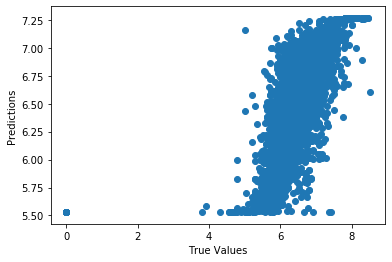

In [292]:
## The line / model
_=plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

> <font color=brown>Cross Validation</font>

In [293]:
MSEs = cross_val_score(lasso, X, y, scoring='neg_mean_squared_error', cv=5 )

In [294]:
mean_MSE = np.mean(MSEs)
print(mean_MSE)

-0.0645772126880459


In [295]:
MSEs

array([-0.1227483 , -0.04788169, -0.05580965, -0.05183286, -0.04461357])